In [1]:
import pprint as pp

import matplotlib as mpl
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.collections import PolyCollection
pp.PrettyPrinter(indent=4)
from typing import Tuple, Union, List
import numpy as np
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Circle
import tensorflow as tf
from tensorflow.keras.utils import load_img

from src.utils.funcs import init_COCO, process_img_annotations, rotate
from src.utils.classes import CategoricalDataGen, bbox_worker
from src.models.models import IoU, YOLOLoss
from src.utils.box_cutter import BoundingBox_Processor

from IPython.display import HTML



2023-01-04 10:35:04.875787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 10:35:04.940512: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
%aimport src.utils.box_cutter
%aimport src.utils.funcs
%aimport src.utils.classes
%aimport src.models

In [4]:
np.set_printoptions(formatter={'float_kind':"{:.4f}".format})

In [5]:
data = init_COCO("./data/", ["train", "val", "test"])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 55 val images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 60 test images


In [6]:
test = CategoricalDataGen('test', data, "./data/images", target_size=(384, 512))

In [7]:
xdivs = 12
ydivs = 9

In [8]:
labels = test.get_labels(divs=(ydivs, xdivs), num_classes=13, num_boxes=3,
                input_size=(1440, 1920))
labels.shape

(60, 12, 9, 19)

In [9]:
preds = np.zeros((60, xdivs, ydivs, 13 + 3 * 6), dtype=np.float32)
preds[...,:19] = preds[...,:19] + labels
preds[..., 19:25] = labels[..., 13:19] 
preds[..., 25:] = labels[..., 13:19] bb
b_e = preds[..., 13]
b_e = b_e.reshape((preds.shape[:-1] + (1,)))
print(b_e.shape)
box_exists = np.concatenate((b_e, b_e, b_e, b_e, b_e), axis=-1)
known_loss = np.asarray([10, 10, 5, 20, np.pi * .05])
known_loss = np.full(preds.shape[:-1] + (5,), known_loss, dtype=np.float32)
preds[..., 14:19] = known_loss + preds[..., 14:19]
preds[..., 20:25] = box_exists * (preds[..., 20:25] + np.random.normal(0, 2, preds.shape[:-1] + (5,)))
preds[..., 26:] = box_exists * (preds[..., 26:] + np.random.normal(0, 2, preds.shape[:-1] + (5,)))

(60, 12, 9, 1)


In [10]:
box_cutter = BoundingBox_Processor()

In [11]:
label_corners = box_cutter.get_corners(labels)
pred_corners = box_cutter.get_corners(preds)
pred_corners = pred_corners[0]
label_corners = label_corners[0]
print(pred_corners.shape)

2023-01-04 10:35:21.766109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-04 10:35:21.768211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-04 10:35:21.768233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-04 10:35:21.770746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-04 10:35:21.770796: I tensorflow/com

(60, 12, 9, 4, 2)


In [12]:
true_edges = box_cutter.get_edges(label_corners)
pred_edges = box_cutter.get_edges(pred_corners)
print(pred_edges.shape)

(60, 12, 9, 4, 2, 2)


In [13]:
intersection_points = box_cutter.construct_intersection(label_corners, pred_corners, return_centered=False)

In [14]:
iou = box_cutter.calculate_iou(label_corners, pred_corners)
print(f"IoU: {iou.shape}\n{iou[0, 5]}")

IoU: (60, 12, 9)
[nan nan nan nan 0.1963 nan 0.4273 nan 0.4948]


In [15]:
giou = box_cutter.calculate_GIoU(label_corners, pred_corners)
giou[0, 5]

C shape (60, 12, 9)
Union: (60, 12, 9)
Intersection: (60, 12, 9)


<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([nan, nan, nan, nan, 0.1960, nan, 0.4272, nan, 0.4947],
      dtype=float32)>

In [12]:
img = np.asarray(load_img("./data/images/test/screws_006.png", target_size=(384, 512)), dtype=np.float32)
img = img / 255
fig, ax = plt.subplots(figsize=(xdivs, ydivs))
ax.imshow(img)
y_true = label_corners[0]
print(y_true.shape)
y_true = tf.reshape(y_true, [ydivs * xdivs, 4, 2])
for label in y_true:
    # print(f"Label:\n{label}")
    bbox = label
    ax.add_patch(Polygon(bbox, fill=None, edgecolor='tab:purple', lw=2))
    ax.add_patch(Circle(np.mean(bbox, axis=0), radius=3, fill=None, edgecolor="red", lw=2))
    ax.scatter(bbox[2][0], bbox[2][1], marker='x', color='springgreen', s=60)
    ax.scatter(bbox[0][0], bbox[0][1], marker='x', color='tomato', s=60)
# y_pred = pred_corners[0]
# y_pred = tf.reshape(y_pred, [ydivs * xdivs, 4, 2])
# for pred in y_pred:
#     bbox = pred
#     ax.add_patch(Polygon(bbox, fill=None, edgecolor='tomato', lw=2))
#     ax.add_patch(Circle(np.mean(bbox, axis=0), radius=3, fill=None, edgecolor="tab:blue", lw=2))
#     ax.scatter(bbox[2][0], bbox[2][1], marker='x', color='tab:blue', s=60)
#     ax.scatter(bbox[0][0], bbox[0][1], marker='x', color='tab:blue', s=60)
ax.axis('off')
plt.savefig('./screws_with_label_boxes.png')
plt.show()

tf.Tensor(
[[51.1651 25.8246 1.0000]
 [69.0193 27.2821 1.0000]
 [75.9566 -1.2481 1.0000]
 [25.2475 -13.5783 1.0000]
 [-110.2454 -24.6385 1.0000]
 [-111.1431 -13.6418 1.0000]
 [0.0000 0.0000 1.0000]
 [0.0000 0.0000 1.0000]], shape=(8, 3), dtype=float32)
tf.Tensor(
[[[51.1651 25.8246 1.0000]
  [69.0193 27.2821 1.0000]]

 [[75.9566 -1.2481 1.0000]
  [25.2475 -13.5783 1.0000]]

 [[-110.2454 -24.6385 1.0000]
  [-111.1431 -13.6418 1.0000]]

 [[0.0000 0.0000 1.0000]
  [0.0000 0.0000 1.0000]]], shape=(4, 2, 3), dtype=float32)
triangle_matrix: (60, 12, 9, 4, 2, 3)


In [ ]:
print(label_corners[0, 5, 6].shape,label_corners[0, 5, 6].shape)
test_box = label_corners[0, :, :]
test_pred = pred_corners[0, :, :]
test_intr = tf.constant(intersection_points[0, :, :, :8])

In [13]:
for idx in range(6):

    break

(60, 12, 9, 4, 2, 2)


In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set(
        xlim=[0, 512],
        ylim=[0, 384],
        xticks=list(range(0, 512,int(512/12))),
        yticks=list(range(0, 384, int(384/9))),
        # yticklabels=np.linspace(0, 9, 10),
        # xticklabels=np.linspace(0, 12, 13)
        )
ax.grid(visible=True, zorder=0)
ax.set_title("Example of Calculated Shape Intersection")
ax.imshow(np.asarray(load_img("./data/images/test/screws_006.png", target_size=(384, 512))), zorder=0, alpha=.6)
ax.set_facecolor('black')
for cell in range(12 * 9):
    cl = divmod(cell, 12) 
    check = tf.cast(tf.reduce_sum(test_box[cl[1], cl[0]]) < .001, dtype=tf.bool).numpy()
    if check:
        continue
    mask = tf.cast(tf.reduce_sum(test_intr[cl[1], cl[0]], axis=-1) > 0.001, dtype=tf.bool)
    test_inter_ma = tf.boolean_mask(test_intr[cl[1], cl[0]], mask)
    ax.add_patch(Polygon(test_box[cl[1], cl[0]], fill=None, edgecolor='chartreuse', lw=1, zorder=20))
    ax.add_patch(Polygon(test_pred[cl[1], cl[0]], fill=None, edgecolor='fuchsia', lw=1, zorder=20))
    ax.add_patch(Polygon(test_inter_ma, facecolor='palegreen', edgecolor='springgreen', lw=1, alpha=.4, zorder=10))
ax.axhline(0, -10, 10, lw=1, color='black', linestyle='--', zorder=5)
ax.axvline(0, -10, 10, lw=1, color='black', linestyle='--', zorder=5)
plt.savefig("./images/bbox_intersection.png")
plt.show()

[array([5.1807, 7.7800]),
 array([4.2809, 3.8825]),
 array([2.8193, 4.2200]),
 array([3.7191, 8.1175])]

In [16]:
mpl.rcParams['animation.embed_limit'] = 400
fig, ax = plt.subplots(figsize=(8,6))
ax.set(
        xlim=[0, 512],
        ylim=[0, 384],
        xticks=list(range(0, 512,int(512/12))),
        yticks=list(range(0, 384, int(384/9))),
        # yticklabels=np.linspace(0, 9, 10),
        # xticklabels=np.linspace(0, 12, 13)
        )
ax.grid(visible=True, zorder=0)
ax.set_title("Example of Calculated Shape Intersection")
ax.set_facecolor('black')
ax.imshow(np.asarray(load_img("./data/images/test/screws_006.png", target_size=(384, 512))), zorder=0, alpha=.6)
def show_frame(frame):
    for cell in range(0 + frame, 9 * 12, 1):
        cl = divmod(cell, 12) 
        check = tf.cast(tf.reduce_sum(test_box[cl[1], cl[0]]) < .001, dtype=tf.bool).numpy()
        if check:
            return None, timer 
        y_true = Polygon(test_box[cl[1], cl[0]], fill=None, edgecolor='chartreuse', lw=1, zorder=20)
        y_pred = Polygon(test_pred[cl[1], cl[0]], fill=None, edgecolor='fuchsia', lw=1, zorder=20)
        intersection = Polygon(test_inter_ma, facecolor='palegreen', edgecolor='springgreen', lw=1, alpha=.4, zorder=10)
        timer = frame
        return True, timer,   
        

def animation(i):
    check,  = show_frame(i)
    if not check:
        return
    mask = tf.cast(tf.reduce_sum(test_intr[cl[1], cl[0]], axis=-1) > 0.001, dtype=tf.bool)
    test_inter_ma = tf.boolean_mask(test_intr[cl[1], cl[0]], mask)
    ax.add_patch(y_true)
    ax.add_patch()
    ax.add_patch()

pillow = PillowWriter(fps=15)
ax.axhline(0, -10, 10, lw=1, color='black', linestyle='--', zorder=5)
ax.axvline(0, -10, 10, lw=1, color='black', linestyle='--', zorder=5)
anim = FuncAnimation(fig, animation, frames=9*12)
# anim.save("./images/intersection_anim.gif", writer=pillow, dpi=100)
HTML(anim.to_jshtml(fps=15))
# plt.close()

tf.Tensor(
[[279.6179 159.3425]
 [265.7286 144.4976]
 [218.5303 188.6575]
 [232.4196 203.5024]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[295.0650 158.3904]
 [275.0793 142.8293]
 [223.0832 209.6096]
 [243.0689 225.1707]], shape=(4, 2), dtype=float32)


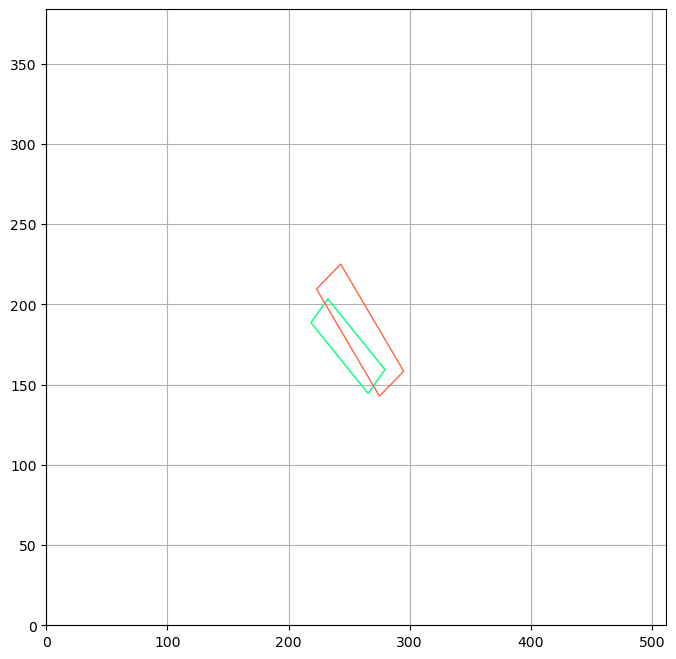

In [17]:
points = []
knudge = 512 / 12
start = np.array([knudge/2, knudge/2])
for cell in range(12 * 9):
    v, u = divmod(cell, 12)
    points.append(start + [u*knudge, v*knudge])
    x, y = [[x for x, y in points],
            [y for x, y in points]]
    print(x[:10])
    plt.scatter(x, y)

In [ ]:
def find_cells(test_box, test_pred, test_intr):
    result = []
    print(test_box.shape)
    x_dim, y_dim = test_box.shape[0:2]
    for cell in range(x_dim * y_dim):
        x, y = divmod(cell, x_dim) 
        check = tf.cast(tf.reduce_sum(test_box[y, x]) < .001, dtype=tf.bool).numpy()
        if check:
            continue
        print(test_intr[y, x])
        mask = tf.cast(tf.reduce_sum(test_intr[y, x], axis=-1) > 0.001, dtype=tf.bool)
        y_intr = tf.boolean_mask(test_intr[y, x], mask)
        print(y_intr)
        y_true = test_box[y, x]
        y_pred = test_pred[y, x]
        result.append((y_true, y_pred, y_intr)) 
    return result

In [ ]:
poly_list = find_cells(test_box, test_pred, test_intr)
print(len(poly_list))
print(poly_list[0][2])

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
def animation(i):
    if i > 0:
        ax.clear()
    ax.tick_params(axis="both",
                   which="both",
                   bottom=False,
                   left=False,
                   labelbottom=False,
                   labelleft=False)
    ax.set(
            xlim=[0, 512],
            ylim=[0, 384],
            xticks=list(range(0, 512,int(512/12))),
            yticks=list(range(0, 384, int(384/9))),
            # yticklabels=np.linspace(0, 9, 10),
            # xticklabels=np.linspace(0, 12, 13)
            )
    ax.grid(visible=True, color="black", zorder=0)
    ax.set_title("Example of Calculated Shape Intersection")
    ax.imshow(np.asarray(load_img("./data/images/test/screws_006.png", target_size=(384, 512))), zorder=0, alpha=1)
    ax.add_patch(Polygon(poly_list[i][0], fill=None, edgecolor='chartreuse', lw=1, zorder=20))
    ax.add_patch(Polygon(poly_list[i][1], fill=None, edgecolor='fuchsia', lw=1, zorder=20))
    ax.add_patch(Polygon(poly_list[i][2], facecolor='palegreen', edgecolor='springgreen', lw=1, alpha=.5, zorder=10))

anim = FuncAnimation(fig, animation, frames=len(poly_list))
# anim.save("./images/intr_anim3.gif", fps=1)
plt.close()

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
for i in range(len(poly_list)):
    ax.clear()
    box = poly_list[i][0].numpy()
    maxX, maxY = np.max(box.T, axis=-1)
    minX, minY = np.min(box.T, axis=-1)
    size = np.max([maxX - minX, maxY - minY]) + 50
    max = np.max(box.T, axis=-1)
    min = np.min(box.T, axis=-1)
    center = (max - min) / 2 + min
    x_limit = [center[0] - size/2, center[0] + size/2]
    y_limit = [center[1] - size/2, center[1] + size/2]
    ax.tick_params(axis="both",
                   which="both",
                   bottom=False,
                   left=False,
                   labelbottom=False,
                   labelleft=False)
    ax.set(
            xlim=x_limit,
            ylim=y_limit,
            xticks=list(range(round(x_limit[0]), round(x_limit[1]),int(512/12))),
            yticks=list(range(round(y_limit[0]), round(y_limit[1]), int(384/9))),
            # yticklabels=np.linspace(0, 9, 10),
            # xticklabels=np.linspace(0, 12, 13)
            )
    ax.grid(visible=True, color="gray", zorder=0)
    ax.set_title("Calculate Intersection", fontsize=14)
    ax.add_patch(Polygon(poly_list[i][0], fill=None, edgecolor='tab:blue', lw=1.5, zorder=20))
    ax.add_patch(Polygon(poly_list[i][1], fill=None, edgecolor='tab:gray', lw=1.5, zorder=20))
    ax.add_patch(Polygon(poly_list[i][2], fill=None, edgecolor='springgreen', lw=4.5, zorder=200, alpha=.3))
    ax.add_patch(Polygon(poly_list[i][2], facecolor='gray', edgecolor=None, alpha=.5, zorder=100))
    # plt.savefig(f"./images/intr_shape_{i:03d}")
plt.show()